In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the main data and convert index to datetime
data = pd.read_csv("data/Hawthorne/Site_3006_raw.csv", index_col=0)
data.index = pd.to_datetime(data.index, errors='coerce')

# Load the UV data and convert index to datetime
UVdata = pd.read_csv("data/UV Data/UV Data All Time HW LP RB.csv", index_col=0)
UVdata = UVdata[['HW']]
UVdata.index = pd.to_datetime(UVdata.index, errors='coerce')

# Merge the dataframes by their date indices
data = data.merge(UVdata, left_index=True, right_index=True)

data.rename(columns={'HW': 'UV'}, inplace=True)

# Only keep UV values greater than zero
data['UV'] = data['UV'].where(data['UV'] > 10) #Change this as needed
data['NO'] = data['NO'].where(data['NO'] > 0)
data["NO2"] = data["NO2"].where(data["NO2"] > 0)
data["O3"] = data["O3"].where(data["O3"] > 0)

# Drop any rows with NaN values and filter for positive SR_Synoptic
data.dropna(inplace=True)
data.head()



/var/folders/8y/j4zbl6y95zn4hrbsnlzpz6yc0000gn/T/ipykernel_63682/1486018700.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  UVdata.index = pd.to_datetime(UVdata.index, errors='coerce')


,NO,NO2,O3,SR,Temp,SR_Synoptic,UV
datetime,,,,,,,
2023-04-28 09:00:00,2.200000,6.15,0.052,0.98,59.0,137.0,19.0
2023-04-28 12:00:00,2.566667,7.85,0.059,1.32,66.0,686.0,18.0
2023-04-28 13:00:00,1.433333,5.55,0.066,1.28,66.0,813.0,12.0
2023-04-28 14:00:00,0.933333,4.60,0.070,1.17,68.0,893.0,23.0
2023-04-28 15:00:00,0.800000,4.45,0.071,0.99,69.0,920.0,18.0


## Calculating K
- Convert Temp to K
- Calculate K

In [39]:
# Coversion
data['Temp[K]'] = (data['Temp'] - 32) * 5/9 + 273.15

# K calc
A = 3.0e-12
EoR = 1500
data['K'] = A * np.exp(-EoR / (data['Temp[K]'])) #This unit seems to be cm**3 Molecules**-1 s**-1

f298 = 1.07
g = 130
data['f_T'] = f298 * np.exp(g * (1/data['Temp[K]'] - 1/298.0))


## Calculating J

In [40]:
C=7.784e-5 
data['J']=C*data['UV'] 


# Change concentration units
- Ozone ppm -> ppb -> ppbv
- NO ppb -> ppbv
- NOx ppb -> ppbv

In [50]:
# Ideal gas number density (molecules/cm^3)
kB = 1.380649e-23  # J/K
P = 87000         # Pa
T = data['Temp[K]']

n_air = (P / (kB * T)) / 1e6  # molecules/cm^3


# Convert mixing ratios to molecules/cm^3
data['O3_mol_per_cm3']  = data['O3']  * 1e-6 * n_air   # ppm -> molecules/cm^3
data['NO_mol_per_cm3']  = data['NO']  * 1e-9 * n_air   # ppb -> molecules/cm^3
data['NO2_mol_per_cm3'] = data['NO2'] * 1e-9 * n_air   # ppb -> molecules/cm^3

# data['O3_mol_per_cm3'] = data['O3'] * 1000 * 2.46E10

# data['NO_mol_per_cm3'] = data['NO'] * 2.46E10

# data['NO2_mol_per_cm3'] = data['NO2'] * 2.46E10



datetime
2023-04-28 09:00:00    0.220922
2023-04-28 12:00:00    0.190842
2023-04-28 13:00:00    0.143992
2023-04-28 14:00:00    0.326061
2023-04-28 15:00:00    0.281742
                         ...   
2025-10-08 10:00:00    0.177285
2025-10-08 11:00:00    0.212617
2025-10-08 12:00:00    0.217518
2025-10-08 13:00:00    0.206190
2025-10-08 14:00:00    0.201352
Name: LR, Length: 3546, dtype: float64


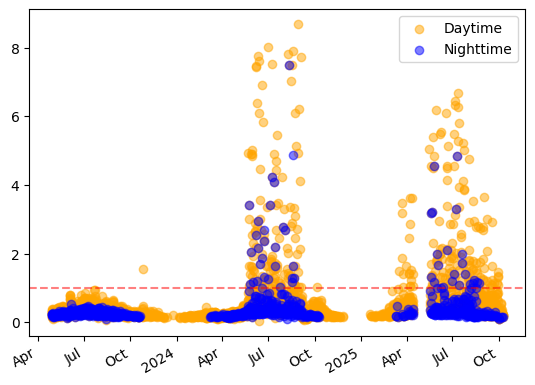

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data['LR'] = (data['J']*data['NO2_mol_per_cm3'])/(data['K']*data['O3_mol_per_cm3']*data['NO_mol_per_cm3'])
# data['LR'] = data['LR'].apply(lambda x: x if x >= -40 else np.nan)
# data['LR'] = data['LR'].apply(lambda x: x if x <= 40 else np.nan)
#data['LR'] = data['LR'].apply(lambda x: np.nan if x == 0 else x)

# data['LR'] = data['LR'].apply(lambda x: np.log(x))
data.dropna(inplace=True)
print(data['LR'])
data.to_csv('data/Hawthorne/Leighton_Relationship_HW.csv')

fig, ax = plt.subplots()

# daytime = data[data['UV'] > 5]
# nighttime = data[data['UV'] <= 5]
daytime = data.between_time('09:00', '16:00')
nighttime = data.between_time('16:00', '09:00')

ax.scatter(daytime.index, daytime['LR'], c='orange', alpha=0.5, label='Daytime')
ax.scatter(nighttime.index, nighttime['LR'], c='blue', alpha=0.5, label='Nighttime')

ax.legend()
ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)






ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.autofmt_xdate()


# Daytime Histogram 

The daytime median LR is 0.4160063046724135
The 10th percentile is 0.19112485853379532 and the 90th percentile is 2.3295706542959302


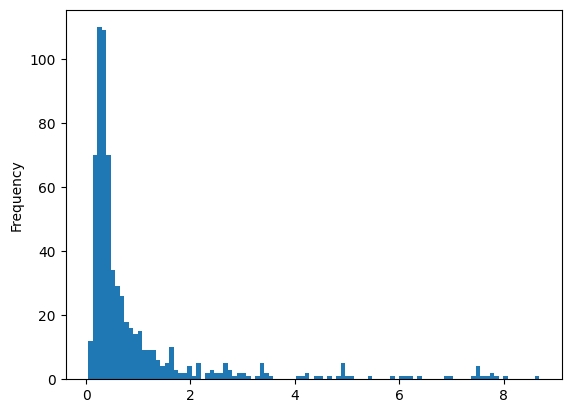

In [56]:
daytime['LR'].plot(kind='hist', bins=100)
median_LR = daytime['LR'].median()
print(f"The daytime median LR is {median_LR}")
print(f"The 10th percentile is {daytime["LR"].quantile(0.1)} and the 90th percentile is {daytime["LR"].quantile(0.9)}")

# Nighttime Histogram

The nightime median LR is 0.2584683259406928


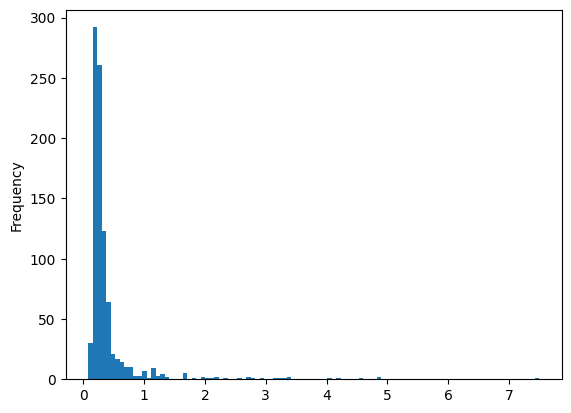

In [53]:
nighttime['LR'].plot(kind='hist', bins=100)
median_LR = nighttime['LR'].median()
print(f"The nightime median LR is {median_LR}")

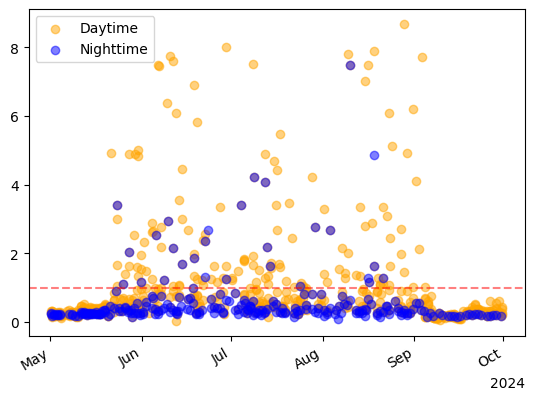

In [54]:
summer_2024 = data.loc['2024-05':'2024-09']
daytime = summer_2024.between_time('09:00', '16:00')
nighttime = summer_2024.between_time('16:00', '09:00')

fig, ax = plt.subplots()
ax.scatter(daytime.index, daytime['LR'], c='orange', alpha=0.5, label='Daytime')
ax.scatter(nighttime.index, nighttime['LR'], c='blue', alpha=0.5, label='Nighttime')
ax.legend()
ax.axhline(y=1, color='r', linestyle='--', alpha=0.5)
# data['LR'].plot(kind='hist', bins=100)





ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.autofmt_xdate()

# Uncertainty 

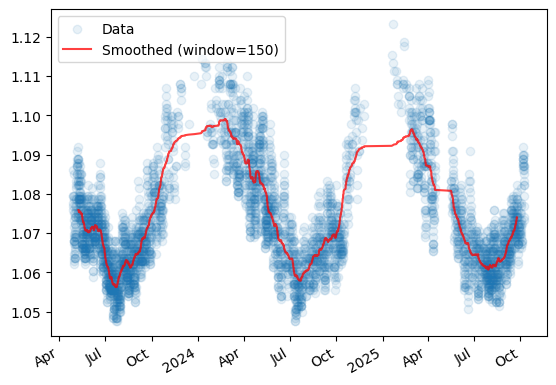

In [55]:
fig, ax = plt.subplots()
ax.scatter(data.index, data['f_T'], alpha=0.1, label='Data')

# Add smoothing line
window_size = 150
smoothed = data['f_T'].rolling(window=window_size, center=True).mean()
ax.plot(data.index, smoothed, color='red', label=f'Smoothed (window={window_size})', alpha=0.75)

ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

fig.autofmt_xdate()
